In [1]:
import numpy as np
import qutip as qtp
from qutip.qip.operations import cnot, snot
from qutip.qip.circuit import QubitCircuit

import random
from numba import jit

import matplotlib.pyplot as plt

## Task 1
### a) define basic states and operatos
As we comment in class, it is possible to use qutip for this first part, later I will use qutip just to define operators and ket vectors

In [2]:
N: int = 1   #number of qubits
HS: int = 2  #Hilbert space

qubit1 = qtp.rand_ket(HS).unit()
qubit1_np = np.asarray(qubit1)
sig_x, sig_y, sig_z = qtp.sigmax(), qtp.sigmay(), qtp.sigmaz() 
sig_x_np, sig_y_np, sig_z_np = np.asarray(sig_x), np.asarray(sig_y), np.asarray(sig_z)
identity = qtp.qeye(HS)
identity_np = np.asarray(identity)
Had = snot(1)
Had_np = np.asarray(Had)

q0, q1 = qtp.basis(HS,0), qtp.basis(HS,1)
q0_jnp, q1_jnp = np.asarray(q0), np.asarray(q1)
plus = q0 + q1
plus = plus.unit()
plus_np = np.asarray(plus)

annihi = q0*q1.dag()
annihi_np = np.asarray(annihi)
creati = q1*q0.dag()
creati_np = np.asarray(creati)

print("qubit: ", qubit1_np)
print("X: ", sig_x)
print("Z: ", sig_z_np)
print("Hadamard: ", Had)
print("Annihilation: ", annihi_np)
print("Creation: ", creati_np)
print('Plus', plus_np)

qubit:  [[0.33585396+0.93526073j]
 [0.10393539+0.04107218j]]
X:  Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]
Z:  [[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]
Hadamard:  Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
Annihilation:  [[0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j]]
Creation:  [[0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j]]
Plus [[0.70710678+0.j]
 [0.70710678+0.j]]


In [3]:
print(qtp.tensor(q1.dag(),q1))

Quantum object: dims = [[1, 2], [2, 1]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]


### b) step 1 to 5 in the Wavefunction Monte Carlo (WFMC)

In [4]:
#step 1
@jit
def prob_f(state: np.ndarray, jumps: np.ndarray, time:float) -> np.ndarray:
    def pro(jumps_o: np.ndarray) -> float:
        p_mu = time*(np.conj(state.T)@np.conj(jumps_o.T)@jumps_o@state)
        return np.real(p_mu[0][0])
    p_mu_f = np.array([pro(x) for x in jumps])
    p0 = np.array([1 - np.sum(p_mu_f)])
    p_mu_f2 = np.concatenate((p0, p_mu_f))
    return p_mu_f2

#step 2 
@jit
def P_n(p_arr: np.array) -> np.ndarray:
    p_count = p_arr[0]
    list_P = [0., p_arr[0]] 
    for i in range(1, len(p_arr)):
        p_count += p_arr[i]
        list_P.append(p_count)
    return np.array(list_P)

#step 3 and 4        
@jit
def mu_hat(p_arr: np.ndarray) -> int:
    r = random.uniform(0, 1)
    mu = np.searchsorted(p_arr, r, side='left') - 1
    return mu

# @jit
def evolve(state: np.ndarray, hamilt, jumps: np.ndarray, time:float) -> np.ndarray:
    pmu_t = prob_f(state, jumps, time)
    prob0 = P_n(pmu_t)
    # print(prob0)
    mu = mu_hat(prob0)
    if mu==0:
        jum_prod = np.array([0.5*np.conj(x.T)@x for x in jumps])
        jump_fin = np.sum(jum_prod, axis=0)
        new_st = (identity_np - 1.j*time*hamilt - time*jump_fin)@state
        new_st *= 1 / np.linalg.norm(new_st)
    else: 
        injump = mu -1
        new_st = (time*jumps[injump])@state
        new_st *= 1 / np.linalg.norm(new_st)
    return new_st

### c) Trajectory

In [5]:
# @jit
def traj(state_i: np.ndarray, time_l: np.ndarray, hamilt, jumps: np.ndarray, tau: float, meas_ope: np.ndarray) -> list[float]:
    state = state_i
    traj_l = []
    for jj in range(len(time_l)):
        if jj==0:
            traj_l.append(np.abs(np.conj(state.T)@meas_ope@state)[0][0])
        else:
            state = evolve(state, hamilt, jumps, tau)
            traj_l.append(np.abs(np.conj(state.T)@meas_ope@state)[0][0])
    return traj_l

In [6]:
# meas_ope = sig_x_np
# state = q0_jnp
# expe = np.abs(np.conj(state.T)@meas_ope@state)[0][0]
# print(expe)

## Task 2 - qubit decay

Having implemented the barebones for WFMC, we can use the algorithm to look at physics problems. The canonical example of this course has been qubit decay. We now want to use the stochastic Schrödinger equation to visualize the decay of a single qubit described by the following master equation
$$ \partial_t \hat{\rho}(t)= \gamma \mathcal{D}\left[\hat{\sigma}_{-}\right] 
\hat{\rho}.$$
We might choose $\gamma = 1$ for this task.

* Simulate a single trajectory up to time $t_{max} = 10 / \gamma$ for the initial state $\vert \psi \rangle = \vert 1 \rangle$ and plot $\vert \langle 1 \vert \psi (t) \rangle\vert^2$ on the y-axis and the time $t$ on the axis. Explain your choice of $\tau$. What should the relation betweeen $\tau$ and $\gamma$ be? What is happening in the physical system?

In my case $\tau = 0.01$, it is a good value, because is not to big, and it also not to small to require a lot of cpu process.

So it is two orders of magnitude different to $1/\gamma$.

The system is having a pure decay

In [7]:
gamma: int = 1
jump2 = np.array([annihi_np])
tau: float = 0.1

q1_meas_ope = np.asarray(qtp.tensor(q1.dag(),q1))
pmu_t2 = prob_f(q1_jnp, jump2, tau)
print(pmu_t2)
pvar_t2 = P_n(pmu_t2)
print(pvar_t2)
mu_t2 = mu_hat(pvar_t2)
print(mu_t2)
time_l2 = np.arange(0,10, tau)
traj_l2 = traj(q1_jnp, time_l2,0, jump2, tau, q1_meas_ope)
# print(time_l2)
print(traj_l2)


/tmp/ipykernel_12484/437509196.py:5: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(complex128, 2, 'C', False, aligned=True), Array(complex128, 2, 'A', False, aligned=True))
  p_mu = time*(np.conj(state.T)@np.conj(jumps_o.T)@jumps_o@state)


[0.9 0.1]
[0.  0.9 1. ]
0
[1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


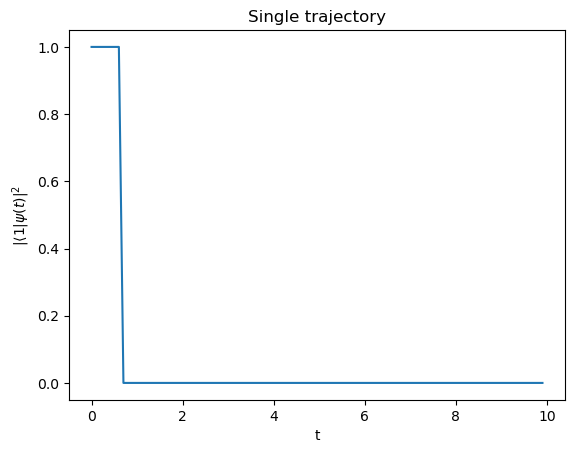

In [8]:
plt.plot(time_l2, traj_l2)
plt.xlabel('t')
plt.ylabel(r'$|\langle 1|\psi(t)|^2$')
plt.title('Single trajectory')
plt.show()



* Now simulate multiple trajectories, you will have to find out yourself how many are necessary. In a new figure, plot each trajectory individually in the same figure, as well as their average. What kind of functional dependence due you expect for the average value $\vert \langle 1 \vert \psi (t) \rangle\vert^2$. Plot this function as well. How well does it agree with the average? How many trajectories were necessary for to find good agreement between the analytical expectation and numerical average?

In time=6 is almost 0, so I will limit the system till that value

[[1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998

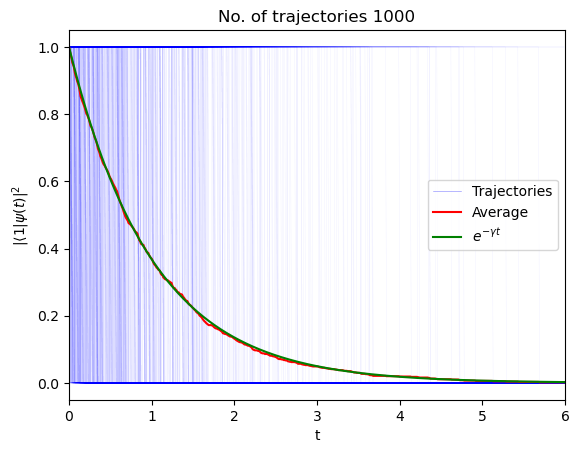

In [9]:
gamma: int = 1
jump2 = np.array([annihi_np])
tau: float = 0.01


list_expec = []
number_run: int = 1000
time_l2 = np.arange(0,6, tau)
for i in range(number_run):
    traj_l2 = traj(q1_jnp, time_l2,0, jump2, tau, q1_meas_ope)
    list_expec.append(traj_l2)

print(list_expec)
# print(traj_l2)    
list_expec_np = np.array(list_expec)
averages_t2 = np.mean(list_expec_np, axis=0)
# std_devs_t2 = np.std(list_expec_np, axis=0)

Decay_f = lambda x,g: np.exp(-g*x)
real_ex = Decay_f(time_l2, gamma)

for i, y in enumerate(list_expec):
    if i==0:
        plt.plot(time_l2, y, color='blue', linewidth=0.4, alpha=0.5, label='Trajectories')  # chr(65) is 'A'
    else:
        plt.plot(time_l2, y, color='blue', linewidth=0.2, alpha=0.1)
        
# Add labels and legend
plt.plot(time_l2, averages_t2, label='Average', color='red')
# plt.fill_between(time_l2, averages_t2 - std_devs_t2, averages_t2 + std_devs_t2, color='red', alpha=0.3)
plt.plot(time_l2, real_ex, color='green', label=r'$e^{-\gamma t}$')
plt.xlim(0,6)
plt.xlabel('t')
plt.ylabel(r'$|\langle 1|\psi(t)|^2$')
plt.legend()
plt.title(f'No. of trajectories {number_run}')
plt.show()

Because it is a decay, we were expecting an exponential decay, and that is what I obtained. ANd the model with 1000 trajectories fix very well to tat exponential decay.


Estimate the error:
$$\mathrm{Error}(N) = \mathrm{Max}_{t}\Big[\vert \mathrm{Num}(N,t) - e^{-\gamma t}\vert \Big]$$
where $N$ is the number of trajectories and Max is the maximum value of these differences.

In [10]:
traj_list = [50, 100, 500]

err_list_av = []
max_err = []
for i in traj_list:
    er_l_2 = []
    for j in range(i):
        # print(j)
        traj_temp = traj(q1_jnp, time_l2,0, jump2, tau, q1_meas_ope)
        er_l_2.append(traj_temp)
    expec_er_l = np.array(er_l_2)
    average_i = np.mean(expec_er_l, axis=0)
    max_val = np.max(np.abs(average_i - real_ex))
    err_list_av.append(max_val)
    
err_list_av.append(np.max(np.abs(averages_t2 - real_ex)))
traj_list.append(number_run)
print(err_list_av)


[0.12493021219858241, 0.04366481659638388, 0.040327284734507196, 0.016358235398805876]


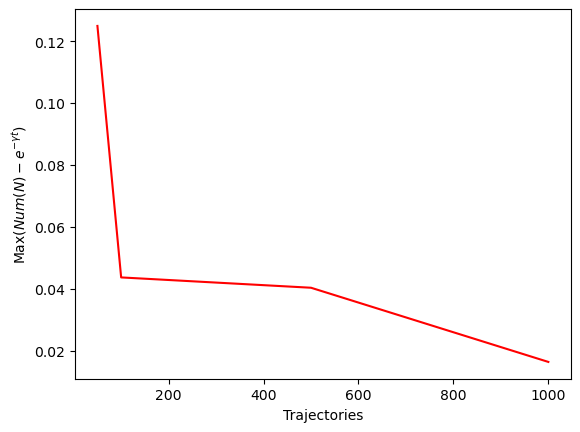

In [11]:
plt.plot(traj_list, err_list_av, color='red')
plt.xlabel('Trajectories')
plt.ylabel(r'Max($Num(N) - e^{- \gamma t}$)')
plt.show()

## Task 2 - Qubit dephasing

We now want to investigate qubit dephasing using the quantum trajectories approach. To this end, consider the master equation 
$$ \partial_t \hat{\rho}(t)= -i \left[\Delta Z, \hat{\rho}\right] + \gamma_{\phi} \mathcal{D}\left[Z\right] 
\hat{\rho},$$
where $\Delta$ is a detuning parameter we will use later. We will simulate now the measurement of the $T_{\phi}$ time.

* Assuming the state $\vert \psi \rangle $ will evolve subject to the above master equation, how should you initialize $\vert \psi \rangle$ and the expectation value of which observable should you calculate in order to estimate $T_{\phi}$?

We have to use the $|+\rangle$ state as our initial state, and also the measurement operator $|+\rangle \langle + |$.

In my case I do not have to adjust the code, because in my function I have as an input variable the measurement operator

In [12]:
delta: float = 0.
hamil_t2 = delta*sig_z_np 
gamma: int = 0.25
tau: float = 0.01

jump_t2_dp = np.array([np.sqrt(gamma)*sig_z_np])
# jump_t2_dp = np.array([sig_z_np])

state_t2_qd = plus_np
time_l_d = gamma*np.arange(0,10, tau)
plus_oper = np.asarray(qtp.tensor(plus.dag(),plus))
# plus_oper = sig_x_np
traj_l_d = traj(state_t2_qd, time_l_d, hamil_t2, jump_t2_dp, tau, plus_oper)


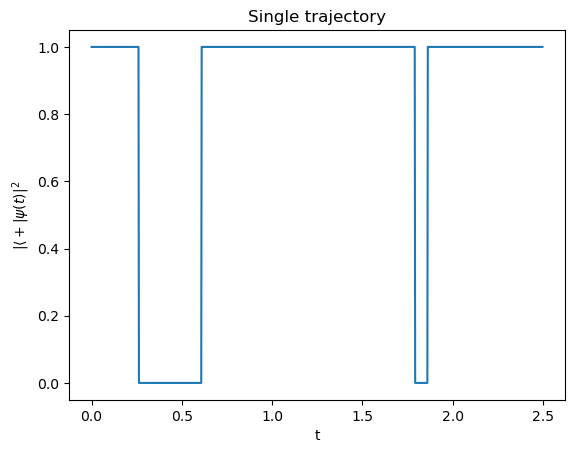

In [13]:
plt.plot(time_l_d, traj_l_d)
plt.xlabel('t')
plt.ylabel(r'$|\langle +|\psi(t)|^2$')
plt.title('Single trajectory')
plt.show()

We have random flips in the phase of $|+\rangle$

* Consider now $\Delta = 0$ and again $\gamma_{\phi} = 0.25$ and simulate multiple trajectories for a suitable choice of $\tau$ until the results converge with analytic form that you derived in Hand-in 1. Again, plot each trajectory individually in the same figure, as well as their average. 

In [14]:
delta: float = 0.
hamil_t2 = delta*sig_z_np 
gamma: int = 0.25
tau: float = 0.01

jump_t2_dp = np.array([np.sqrt(gamma)*sig_z_np])
# jump_t2_dp = np.array([sig_z_np])

state_t2_qd = plus_np
# time_l_d = np.arange(0,10, tau)
# traj_l_d = traj(state_t2_qd, time_l_d, hamil_t2, jump_t2_dp, tau, plus_np)

list_expec_d = []
number_run: int = 2000
time_l_d = np.arange(0,10, tau)
# dephasing_ex = Decay_f(time_l_d, gamma)
for i in range(number_run):
    traj_l_d = traj(state_t2_qd, time_l_d, hamil_t2, jump_t2_dp, tau, plus_oper)
    list_expec_d.append(traj_l_d)
    
list_expec_d_np = np.array(list_expec_d)
averages_t_d = np.mean(list_expec_d_np, axis=0)



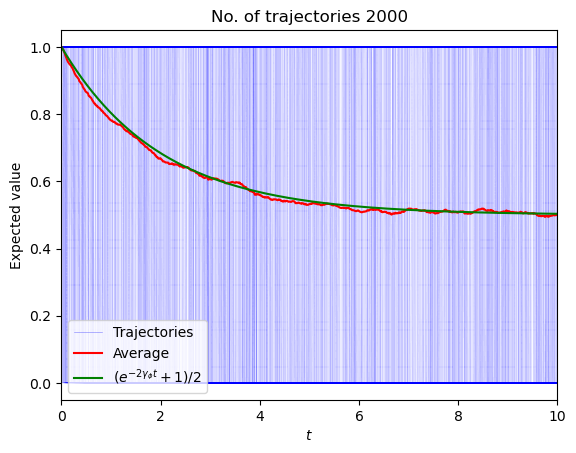

In [15]:

# dephasing_ex = Decay_f(time_l_d, gamma)
for i, y in enumerate(list_expec_d):
    if i==0:
        plt.plot(time_l_d, y, color='blue', linewidth=0.4, alpha=0.5, label='Trajectories')  # chr(65) is 'A'
    else:
        plt.plot(time_l_d, y, color='blue', linewidth=0.15, alpha=0.1)
        
# Add labels and legend
plt.plot(time_l_d, averages_t_d, label='Average', color='red')
# plt.fill_between(time_l2, averages_t2 - std_devs_t2, averages_t2 + std_devs_t2, color='red', alpha=0.3)
plt.plot(time_l_d, (np.exp(-time_l_d * (2*gamma)) + 1)/2, color='green', label=r'$(e^{-2\gamma_{\phi} t} +1)/2$')
plt.xlabel(r'$t$ ')
plt.xlim(0,10)
plt.ylabel(r'Expected value')
plt.legend(loc='lower left')
plt.title(f'No. of trajectories {number_run}')

# Show the plot
plt.show()

It needs more trajectories to convert to as similar as the theoretical

* Now consider non-zero $\Delta$, i.e., $\Delta = 1.5$ and repeat the task above for this parameter set. Additionally, either plot an individual trajectory in another figure or highlight one in the plot with multiple trajectories. Explain what is happening. What is the role of $\Delta$? What has changed in comparison to the case of $\Delta = 0.$

In [16]:
delta: float = 1.5
hamil_t2 = delta*sig_z_np 
gamma: int = 0.25
tau: float = 0.01

jump_t2_dp = np.array([np.sqrt(gamma)*sig_z_np])
state_t2_qd = plus_np
time_l_d2 = np.arange(0,10, tau)
traj_l_d2 = traj(state_t2_qd, time_l_d2, hamil_t2, jump_t2_dp, tau, plus_oper)

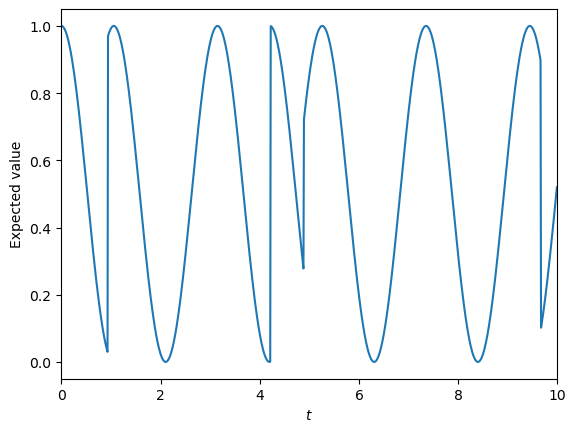

In [17]:
plt.plot(time_l_d2, traj_l_d2)
plt.xlabel(r'$t$ ')
plt.xlim(0,10)
plt.ylabel(r'Expected value')
plt.show()

In [18]:
delta: float = 1.5
hamil_t2 = delta*sig_z_np 
gamma: int = 0.25
tau: float = 0.01

jump_t2_dp = np.array([np.sqrt(gamma)*sig_z_np])
# jump_t2_dp = np.array([sig_z_np])

state_t2_qd = plus_np
# time_l_d = np.arange(0,10, tau)
# traj_l_d = traj(state_t2_qd, time_l_d, hamil_t2, jump_t2_dp, tau, plus_np)

list_expec_d = []
number_run: int = 2000
time_l_d = np.arange(0,10, tau)
# dephasing_ex = Decay_f(time_l_d, gamma)
for i in range(number_run):
    traj_l_d = traj(state_t2_qd, time_l_d, hamil_t2, jump_t2_dp, tau, plus_oper)
    list_expec_d.append(traj_l_d)
    
list_expec_d_np = np.array(list_expec_d)
averages_t_d = np.mean(list_expec_d_np, axis=0)

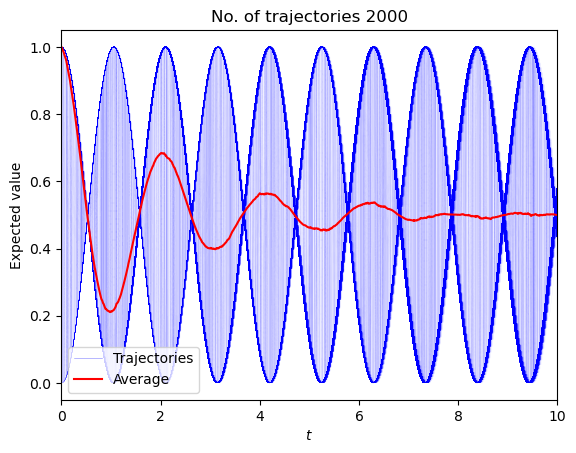

In [19]:

dephasing_ex = Decay_f(time_l_d, 2*gamma)
for i, y in enumerate(list_expec_d):
    if i==0:
        plt.plot(time_l_d, y, color='blue', linewidth=0.4, alpha=0.5, label='Trajectories')  # chr(65) is 'A'
    else:
        plt.plot(time_l_d, y, color='blue', linewidth=0.15, alpha=0.1)
        
# Add labels and legend
plt.plot(time_l_d, averages_t_d, label='Average', color='red')
# plt.fill_between(time_l2, averages_t2 - std_devs_t2, averages_t2 + std_devs_t2, color='red', alpha=0.3)
# plt.plot(time_l_d, dephasing_ex, color='green', label=r'$e^{-2\gamma_{\phi} t}$')
plt.xlabel(r'$t$ ')
plt.xlim(0,10)
plt.ylabel(r'Expected value')
plt.legend(loc='lower left')
plt.title(f'No. of trajectories {number_run}')

# Show the plot
plt.show()

The $\Delta$ is giving use oscillations, so it detunes our system, and we are not in resonance anymore.  

## Determining $T_2$ in a qubit

We now want to combine qubit dephasing and qubit decay in our simulations, i.e, we want to simulate with quantum trajectories the master equation
$$ \partial_t \hat{\rho}(t)= -i \left[\Delta Z, \hat{\rho}\right] + \gamma_{\phi} \mathcal{D}\left[Z\right] 
\hat{\rho} +  + \gamma \mathcal{D}\left[\sigma_{-}\right] 
\hat{\rho},$$

and determine the relaxation time $T_2$ for this model.

* Choose parameters $\gamma_{\phi} = 0.25$, $\gamma = 1.$ and $\Delta = 2.$. Simulate a couple of individual trajectories until you find one in which one can observe both quantum jumps due to $\sigma_{-}$ and $Z$. Plot such a trajectory and describe at which time point which kind of jump occured.

In [20]:
delta: float = 2.
hamil_t2 = delta*sig_z_np 
gamma: int = 0.25
tau: float = 0.01

jump_t2_q = np.array([np.sqrt(gamma)*sig_z_np, annihi_np])
state_t2_qd = plus_np
time_l_q = np.arange(0,10, tau)
traj_l_q = traj(state_t2_qd, time_l_q, hamil_t2, jump_t2_q, tau, plus_oper)

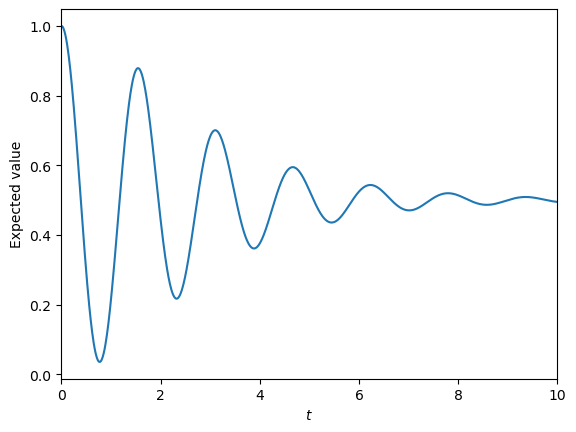

In [21]:
plt.plot(time_l_q, traj_l_q)
plt.xlabel(r'$t$ ')
plt.xlim(0,10)
plt.ylabel(r'Expected value')
plt.show()

 * As usual simulate multiple trajectories and plot them individually, as well as their average and the theoretical model you expect to observe. 

In [22]:
delta: float = 2.
hamil_t2 = delta*sig_z_np 
gamma: int = 0.25
tau: float = 0.01

jump_t2_q = np.array([np.sqrt(gamma)*sig_z_np, annihi_np])
state_t2_qd = plus_np
time_l_q = np.arange(0,10, tau)
list_expec_q = []
number_run: int = 2000
# time_l_d = 2*gamma*np.arange(0,10, tau)
# dephasing_ex = Decay_f(time_l_d, gamma)
for i in range(number_run):
    traj_l_d = traj(state_t2_qd, time_l_q, hamil_t2, jump_t2_q, tau, plus_oper)
    list_expec_q.append(traj_l_d)
    
list_expec_q_np = np.array(list_expec_q)
averages_q_d = np.mean(list_expec_q_np, axis=0)

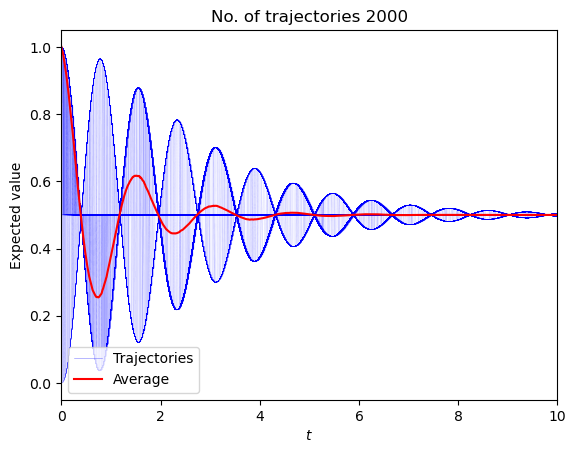

In [23]:
# dephasing_ex = Decay_f(time_l_d, 2*gamma)
for i, y in enumerate(list_expec_q):
    if i==0:
        plt.plot(time_l_q, y, color='blue', linewidth=0.4, alpha=0.5, label='Trajectories')  # chr(65) is 'A'
    else:
        plt.plot(time_l_q, y, color='blue', linewidth=0.15, alpha=0.1)
        
# Add labels and legend
plt.plot(time_l_q, averages_q_d, label='Average', color='red')
# plt.fill_between(time_l2, averages_t2 - std_devs_t2, averages_t2 + std_devs_t2, color='red', alpha=0.3)
# plt.plot(time_l_d, dephasing_ex, color='green', label=r'$e^{-2\gamma_{\phi} t}$')
plt.xlabel(r'$t$ ')
plt.xlim(0,10)
plt.ylabel(r'Expected value')
plt.legend(loc='lower left')
plt.title(f'No. of trajectories {number_run}')

# Show the plot
plt.show()